Make sure to install below requirements:

```
!pip install pennylane
```
```
!pip inatsll pennnylane-qchem
```
After that continue with inporting the required libraries as shown below:

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

**Weighted SSVQE for Kth Excited state:**<br>
This algorithm provides the energy of Kth Excited state for a given Hamiltonian.

Below is the implementation of this algorithm in form of a function that takes input as the Hamiltonian, ansatz, params, k etc. and returns the value for energy in Kth Excited state.

In [16]:
def WEIGHTED_SSVQE(hamiltonian, ansatz, params, opt_name='Adam', stepsize=0.1, iterations=100, k=0, device_name='default.qubit'):
    """Calculates the kth excited state energy for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K for which the Kth excited state energy will be calculated. K <= 2^qubits.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => (Energy, Energies): The function returns a tuple of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)

    #Define the weights for the cost function.
    weights = np.random.random()

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)
    
    # An intermediate Ansatz for total circuit.
    def intermediate_ansatz(params, wires, state_value):
      state_prep(state_value)
      ansatz(params, wires)

    # Cost of each orthogonal state.
    state_cost = qml.ExpvalCost(
        intermediate_ansatz, 
        hamiltonian, 
        device)
    
    # Total cost of the system.
    def total_cost(params):
      cost = []
      for index in range(k+1):
        if index == k:
          cost.append(weights * state_cost(params, state_value=index))
        else:
          cost.append(state_cost(params, state_value=index))
      return sum(cost)

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = []
    
    # Optimization loop.
    for _ in range(iterations):
      params, Energy = optimizer.step_and_cost(total_cost, params)
      energy = state_cost(params, state_value=k)
      energies.append(energy)
    return energies[-1], energies

***Sample Test:***

In [ ]:
#Sample Ansatz:
def ansatz(params, wires):
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

# Molecule Parameters:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

# Hamiltonian:
hamiltonian, qubits =  qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        active_electrons=2,
        active_orbitals=2
)

# Params:
params = np.random.uniform(low=0, high=2*np.pi, size=(8, qubits, 3))

> **Note:** Code given Below may take some time to run.

Energy of Ground state for the given hamiltonian is: -1.1361800803885473
Energy of First Excited state for the given hamiltonian is: -0.5118435711552768


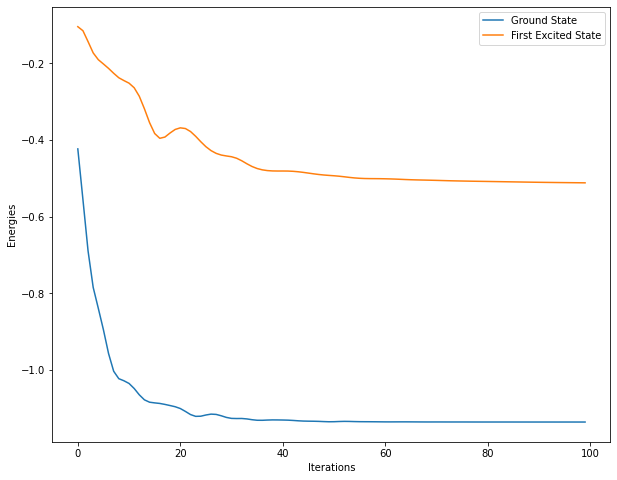

In [17]:
# Calculations:
Energy_G, Energies_G = WEIGHTED_SSVQE(hamiltonian, ansatz, params, stepsize=0.05, k=0)
Energy_1, Energies_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, params, stepsize=0.05, k=1)

# Output:
print('Energy of Ground state for the given hamiltonian is:', Energy_G)
print('Energy of First Excited state for the given hamiltonian is:', Energy_1)

# Graph plot:
Iterations = [*range(0, 100)]
plt.figure(figsize=(10, 8))

plt.plot(Iterations, Energies_G, label='Ground State')
plt.plot(Iterations, Energies_1, label='First Excited State')

plt.xlabel('Iterations')
plt.ylabel('Energies')
plt.legend()
plt.show()

**Weighted SSVQE for all states up to Kth Excited state:**<br>
This algorithm provides the energies of all the states upto Kth Excited state for a given Hamiltonian.

Below is the implementation of this algorithm in form of a function that takes input as the Hamiltonian, ansatz, params, k etc. and returns the value for energies upto Kth Excited state.

In [35]:
def WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, params, opt_name='Adam', stepsize=0.1, iterations=100, k=[0], device_name='default.qubit'):
    """Calculates the energies upto Kth excited state for of a given Hamiltonian.
    
    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'. 
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K till which the excited state energy will be calculated. K <= 2^qubits.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).

    Returns:
        => [[Energy, Energies]]: The function returns a List of List of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)

    #Define the weights for the cost function.
    weights = np.arange(qubits, 0, -1)

    # State Preparation for orthogonal states.
    def state_prep(state_value):
      for index, value in enumerate(np.binary_repr(state_value, qubits)):
        if value == '1':
          qml.PauliX(index)
    
    # An intermediate Ansatz for total circuit.
    def intermediate_ansatz(params, wires, state_value):
      state_prep(state_value)
      ansatz(params, wires)

    # Cost of each orthogonal state.
    state_cost = qml.ExpvalCost(
        intermediate_ansatz, 
        hamiltonian, 
        device)
    
    # Total cost of the system.
    def total_cost(params):
      cost = []
      for index in range(k+1):
          cost.append(weights[index] * state_cost(params, state_value=index))
      return sum(cost)

    # Optimizers options.
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = np.zeros((k+1,iterations))
    
    # Optimization loop.
    for itr in range(iterations):
      params, Energy = optimizer.step_and_cost(total_cost, params)
      for index in range(k+1):
        energy = state_cost(params, state_value=index)
        energies[index][itr] = energy

    # Return Tuples
    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies

> **Note:** Code given Below may take some time to run.

Energy of Ground state for the given hamiltonian is: -1.1360727226958336
Energy of First Excited state for the given hamiltonian is: -0.517024444586761


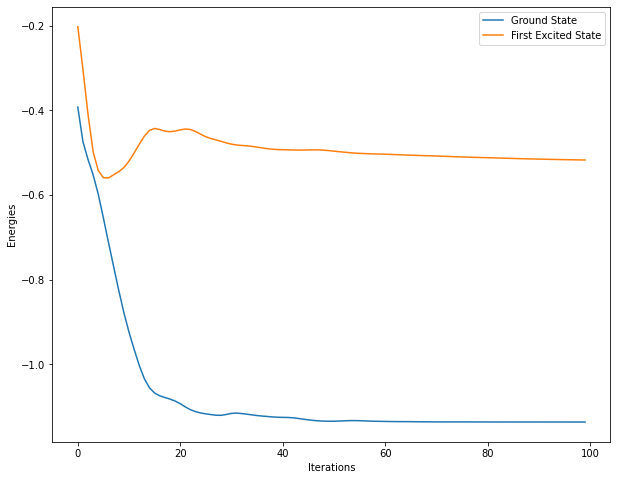

In [36]:
# Calculations:
Energies = WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, params, stepsize=0.05, k=1)

# Output:
print('Energy of Ground state for the given hamiltonian is:', Energies[0][0])
print('Energy of First Excited state for the given hamiltonian is:', Energies[1][0])

# Graph plot:
Iterations = [*range(0, 100)]
plt.figure(figsize=(10, 8))

plt.plot(Iterations, Energies[0][1], label='Ground State')
plt.plot(Iterations, Energies[1][1], label='First Excited State')

plt.xlabel('Iterations')
plt.ylabel('Energies')
plt.legend()
plt.show()

#### From both the graphs, we can easily conclude that both the algorithms are converging at an almost same value of energy of Kth Excited states for the H2 Hamiltonian.

